<a href="https://colab.research.google.com/github/zzaeyun/ESAA23_1/blob/main/%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C_579to590.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **05 콘텐츠 기반 필터링 실습 - TMDB 5000 영화 데이터 세트**
###**장르 속성을 이용한 영화 콘텐츠 기반 필터링**
콘텐츠 기반 필터링은 사용자가 특정 영화를 감상하고 그 영화를 좋아했다면 그 영화와 비슷한 특성/속성, 구성 요소 등을 가진 다른 영화를 추천

<br>

콘텐츠 기반 필터링: 상품/서비스 간의 유사성을 판단하는 기준이 이를 구성하는 다양한 콘텐츠를 기반으로 하는 방식
  - 영화: 장르, 감독, 배우, 평점, 키워드, 영화 설명

<br>

###**데이터 로딩 및 가공**


In [21]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies=pd.read_csv('/tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp...",en,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, ...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289}, {""name"": ""Twentieth Century Fox Film Corporatio...","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}, {""iso_3166_1"": ""GB"", ""name"": ""United ...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,Enter the World of Pandora.,Avatar,7.2,11800


- 4803개의 레코드와 20개의 피처
- 영화 제목, 개요, 인기도, 평점, 투표 수, 예산, 키워드
- 추출할 주요 칼럼
  - id, title, genres, vote_average, vote_count, popularity, keywords, overview
  

In [22]:
movies_df=movies[['id', 'title', 'genres', 'vote_average', 'vote_count', 'popularity', 'keywords', 'overview']]

genres, keywords: 파이썬 리스트 내부에 여러 개의 딕셔너리가 있는 형태

In [23]:
pd.set_option('max_colwidth', 100)
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


여러 개의 개별 장르 데이터를 가지고 있고 name으로 추출
- ast 모듈의 literal_eval( ) 함수를 이용하면 문자열을 문자열이 의미하는 list [dict1, dict2] 객체로 만들 수 있음
- Series 객체의 apply() 에 literal_eval 함수를 적용

In [24]:
from ast import literal_eval
movies_df['genres']=movies_df['genres'].apply(literal_eval)
movies_df['keywords']=movies_df['keywords'].apply(literal_eval)

genres 칼럼은 문자열이 아니라 리스트 내부에 여러 장르 딕셔너리로 구성된 객체를 가짐
- name 키에 해당하는 장르명만 리스트 객체로 추출
- apply lambda 식 사용

In [25]:
movies_df['genres']=movies_df['genres'].apply(lambda x: [y['name'] for y in x])
movies_df['keywords']=movies_df['keywords'].apply(lambda x: [y['name'] for y in x])
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


### **장르 콘텐츠 유사도 측정**

- genres 칼럼은 여러 개의 개별 장르가 리스트로 구성
- genres를 문자열로 변경한 뒤 이를 CountVectorizer로 피처 벡터화한 행렬 데이터 값을 코사인 유사도로 비교
  - 문자열로 변환한 genres 칼럼을 Count 기반으로 피처 벡터화 변환
  - genres 문자열을 피처 벡터화 행렬로 변환한 데이터 세트를 코사인 유사도를 통해 비교
  - 장르 유사도가 높은 영화 중에 평점이 높은 순으로 영화 추천

<br>

- apply(lambda x: (' ').join(x)): 개별 요소를 공백 문자로 구분하는 문자열로 반환

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

movies_df['genres_literal']=movies_df['genres'].apply(lambda x: (' ').join(x))
count_vect=CountVectorizer(min_df=0, ngram_range=(1,2))
genre_mat=count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


사이킷런의 cosine_similarity( ): 코사인 유사도 계산

In [27]:
from sklearn.metrics.pairwise import cosine_similarity

genre_sim=cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:2])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]
 [0.59628479 1.         0.4        ... 0.         0.         0.        ]]


genre_sim: movies_df DataFrame의 행별 장르 유사도 값을 가지고 있음
- movies_df의 개별 레코드에 대해서 가장 장르 유사도가 높은 순으로 다른 레코드를 추출해야 하는데 이를 위해 genre_sim 객체 사용
- argsort()[:,::-1]: 유사도가 높은 순으로 정리된 genre_sim 객체의 비교 행 위치 인덱스 값을 얻을 수 있음


In [28]:
genre_sim_sorted_ind=genre_sim.argsort()[:,::-1]
print(genre_sim_sorted_ind[:1])

[[   0 3494  813 ... 3038 3037 2401]]


###**장르 콘텐츠 필터링을 이용한 영화 추천**
- find_sim_movies(): 장르 유사도에 따라 영화를 추천하는 함수
  - genre_sim_sorted_ind, 고객이 선정한 추천 기준이 되는 영화 제목, 추천할 영화 건수 입력하면 추천된 영화 정보를 가지는 DataFrame 반환
  


In [29]:
def find_sim_movie(df,sorted_ind, title_name, top_n=10):
  title_movie=df[df['title']==title_name]

  title_index=title_movie.index.values
  similar_indexes=sorted_ind[title_index, :(top_n)]

  print(similar_indexes)
  similar_indexes=similar_indexes.reshape(-1)

  return df.iloc[similar_indexes]

In [30]:
similar_movies=find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


- 대부 2편과 좋은 친구들: 대부와 비슷한 유형
- 이해하기 어려운 영화와 평점이 낮은 영화가 있으므로 개선이 필요
- 좀 더 많은 후보군을 선정한 뒤에 영화의 평점에 따라 필터링해서 최종 추천하는 방식으로 변경
  - vote_average값 이용
  - vote_average는 여러 관객이 평가한 평점 평균
  - 소수의 관객이 특정 영화에 만점이나 매우 높은 평점을 부여해 왜곡된 데이터를 가짐
  

In [31]:
movies_df[['title','vote_average','vote_count']].sort_values('vote_average', ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


왜곡된 평점 데이터를 회피할 수 있도록 평점에 평가 횟수를 반영할 수 있는 새로운 평가 방식이 필요
- 가중치가 부여된 평점 (Weighted Rating) 방식 사용

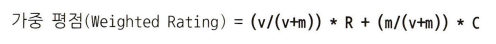

- v: 개별 영화에 평점을 투표한 횟수: vote_count
- m: 평점을 부여하기 위한 최소 투표 횟수
- R: 개별 영화에 대한 평균 평점: vote_average
- C: 전체 영화에 대한 평균 평점

In [32]:
C=movies_df['vote_average'].mean()
m=movies_df['vote_count'].quantile(0.6)
print('C: ', round(C, 3), 'm: ', round(m, 3))

C:  6.092 m:  370.2


In [33]:
percentile=0.6
m=movies_df['vote_count'].quantile(percentile)
C=movies_df['vote_average'].mean()

def weighted_vote_average(record):
  v=record['vote_count']
  R=record['vote_average']

  return((v/(v+m))*R)+((m/(m+v))*C)

In [34]:
movies_df['weighted_vote']=movies.apply(weighted_vote_average, axis=1)

In [35]:
movies_df[['title','vote_average','weighted_vote','vote_count']].sort_values('weighted_vote',ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


In [41]:
def find_sim_movie(df,sorted_ind, title_name, top_n=10):
  title_movie=df[df['title']==title_name]
  title_index=title_movie.index.values

  similar_indexes=sorted_ind[title_index, :(top_n*2)]
  similar_indexes=similar_indexes.reshape(-1)

  similar_indexes=similar_indexes[similar_indexes!=title_index]

  return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]

similar_movies=find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather',10)
similar_movies[['title', 'vote_average', 'weighted_vote']]

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427
